### Install libraries

In [1]:
%pip install numpy pandas scikit-learn matplotlib networkx pm4py


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


PM4PY DOCS: https://pm4py-source.readthedocs.io/en/latest/py-modindex.html
https://processintelligence.solutions/static/api/2.7.11/index.html

### Import packages

In [12]:
import pm4py
import os
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.objects.process_tree.obj import ProcessTree, Operator
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import zipfile

### Approximate Inductive Miner

In [3]:
class ApproximateInductiveMiner:
    def __init__(self, filter_steps=10):
        self.filter_values = [x / filter_steps for x in range(1, filter_steps)]

    def filter_event_log(self, log, threshold):
        """
        Dynamically filter activities based on occurrence threshold.
        Incorporates adjustment for information loss as per AIM.
        """
        activity_counts = pm4py.get_event_attribute_values(log, "concept:name")
        max_count = max(activity_counts.values())

        filtered_log = []
        for trace in log:
            valid_trace = all(
                activity_counts.get(ev["concept:name"], 0) >= max_count * threshold
                for ev in trace
            )
            if valid_trace:
                filtered_log.append(trace)

        # Adjust quality for information loss
        info_loss_factor = len(filtered_log) / len(log) if log else 1
        return filtered_log, info_loss_factor

    def calculate_relations(self, log):
        """
        Create a directly-follows matrix for the log.
        """
        activities = list(pm4py.get_event_attribute_values(log, "concept:name"))
        matrix = np.zeros((len(activities), len(activities)))

        for trace in log:
            for i in range(len(trace) - 1):
                a = activities.index(trace[i]["concept:name"])
                b = activities.index(trace[i + 1]["concept:name"])
                matrix[a][b] += 1

        return matrix

    def estimate_quality(self, operator, clusters, relations, info_loss_factor):
        """
        Operator-specific quality estimation incorporating information loss.
        """
        cluster_0_indices = np.where(clusters == 0)[0]
        cluster_1_indices = np.where(clusters == 1)[0]

        inter_cluster = relations[np.ix_(cluster_0_indices, cluster_1_indices)].sum()
        intra_cluster = relations[np.ix_(cluster_0_indices, cluster_0_indices)].sum() + \
                        relations[np.ix_(cluster_1_indices, cluster_1_indices)].sum()

        if operator == "sequence":
            quality = inter_cluster / (inter_cluster + intra_cluster + 1)
        elif operator == "parallel":
            quality = 2 * inter_cluster * intra_cluster / (inter_cluster ** 2 + intra_cluster ** 2 + 1)
        elif operator == "exclusive":
            quality = 1 / (inter_cluster + intra_cluster + 1)
        elif operator == "loop":
            quality = inter_cluster / (intra_cluster + 1)
        else:
            quality = 0

        return quality * info_loss_factor

    def cluster_relations(self, relations, operator):
        """
        Perform clustering using KMeans and operator-specific distance measures.
        """
        if relations.shape[0] < 2:
            return np.zeros(relations.shape[0], dtype=int)

        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(relations)

        return clusters

    def find_best_cut(self, log):
        """
        Evaluate cuts dynamically over filter parameters.
        """
        best_cut = None
        best_quality = -float('inf')

        for filter_value in self.filter_values:
            filtered_log, info_loss_factor = self.filter_event_log(log, filter_value)
            if not filtered_log:
                continue

            relations = self.calculate_relations(filtered_log)
            if relations.size == 0:
                continue

            for operator in ["sequence", "parallel", "exclusive", "loop"]:
                clusters = self.cluster_relations(relations, operator)
                if len(set(clusters)) < 2:
                    continue

                quality = self.estimate_quality(operator, clusters, relations, info_loss_factor)
                if quality > best_quality:
                    best_cut = (operator, clusters)
                    best_quality = quality

        return best_cut

    def split_log(self, log, cut):
        """
        Split log into sub-logs based on clustering results.
        """
        left, right = [], []
        operator, clusters = cut

        activity_names = list(pm4py.get_event_attribute_values(log, "concept:name"))
        activity_to_cluster = {activity_names[i]: clusters[i] for i in range(len(clusters))}

        for trace in log:
            left_trace, right_trace = [], []
            for ev in trace:
                cluster_index = activity_to_cluster.get(ev["concept:name"], -1)
                if cluster_index == 0:
                    left_trace.append(ev)
                elif cluster_index == 1:
                    right_trace.append(ev)

            if left_trace:
                left.append(left_trace)
            if right_trace:
                right.append(right_trace)

        return left, right

    def discover_process_tree(self, log):
        base_case = self.check_base_case(log)
        if base_case:
            return base_case

        cut = self.find_best_cut(log)
        if cut:
            left_log, right_log = self.split_log(log, cut)
            if not left_log or not right_log:
                return self.create_flower_model(log)

            left_tree = self.discover_process_tree(left_log)
            right_tree = self.discover_process_tree(right_log)

            root = ProcessTree(operator=self.get_operator(cut[0]))
            root.children.append(left_tree)
            root.children.append(right_tree)
            return root

        return self.create_flower_model(log)

    def check_base_case(self, log):
        if not log:
            return ProcessTree(operator=Operator.TAU)

        activities = set(ev["concept:name"] for trace in log for ev in trace)
        if len(activities) == 1:
            activity = next(iter(activities))
            return ProcessTree(label=activity)

        return None

    def create_flower_model(self, log):
        """
        Create a flower model as a fallback for unsplittable logs.
        """
        activities = set(ev["concept:name"] for trace in log for ev in trace)
        root = ProcessTree(operator=Operator.PARALLEL)
        for activity in activities:
            root.children.append(ProcessTree(label=activity))
        return root

    def get_operator(self, operator_str):
        """
        Map string operator to ProcessTree operator.
        """
        return {
            "sequence": Operator.SEQUENCE,
            "exclusive": Operator.XOR,
            "parallel": Operator.PARALLEL,
            "loop": Operator.LOOP
        }.get(operator_str, Operator.SEQUENCE)


    def evaluate_model(self, log, process_tree):
        try:
            net, initial_marking, final_marking = pm4py.objects.conversion.process_tree.converter.apply(process_tree)

            fitness = fitness_evaluator.apply(log, net, initial_marking, final_marking)
            precision = precision_evaluator.apply(log, net, initial_marking, final_marking)
            size = len(str(process_tree))

            return {
                "fitness": fitness,
                "precision": precision,
                "size": size
            }
        except Exception as e:
            print("Error during evaluation:", e)
            return {
                "fitness": None,
                "precision": None,
                "size": None
            }

### Evaluation

1. Extracts the event logs from a zip file

In [25]:
zip_path = "..\data\event_logs.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("..\data")

extract_path = "..\data\event_logs"

# List the extracted files
extracted_files = os.listdir(extract_path)

print("Event Logs: ", extracted_files)

Event Logs:  ['BPIC_2012.xes', 'BPIC_2013_1.xes', 'BPIC_2013_2.xes', 'BPIC_2015_1.xes', 'BPIC_2015_2.xes', 'BPIC_2015_3.xes', 'BPIC_2015_4.xes', 'BPIC_2015_5.xes', 'BPIC_2017.xes', 'BPIC_2019.xes', 'BPIC_2020_1.xes', 'BPIC_2020_2.xes', 'BPIC_2020_3.xes', 'BPIC_2020_4.xes', 'BPIC_2020_5.xes', 'RTFMP.xes', 'SEPSIS.xes']


2. Processes each file using the Approximate Inductive Miner

In [24]:
# Initialize the miner
aim = ApproximateInductiveMiner()

# Placeholder for results
algorithm_results = []

# Process each event log file
for file in extracted_files:
    file_path = os.path.join(extract_path, file)
    try:
        # Import the event log
        log = xes_importer.apply(file_path)
        
        # Discover the process tree using the miner
        process_tree = aim.discover_process_tree(log)
        
        # Evaluate the discovered model
        evaluation_metrics = aim.evaluate_model(log, process_tree)
        
        # Extract fitness and precision
        fitness_data = evaluation_metrics.get('fitness', {})
        average_fitness = fitness_data.get('averageFitness', None)  # Extract averageFitness
        evaluation_metrics['averageFitness'] = average_fitness
        evaluation_metrics.pop('fitness', None)  # Remove the nested fitness dictionary
        
        # Ensure the file name is added to evaluation_metrics
        evaluation_metrics['File'] = file
        
        algorithm_results.append(evaluation_metrics)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert results to a DataFrame for visualization
evaluation_results_df = pd.DataFrame(algorithm_results)




c:\Users\Мария\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
aligning log, completed variants :: 100%|██████████| 4366/4366 [00:25<00:00, 171.74it/s]
computing precision with alignments, completed variants :: 100%|██████████| 56841/56841 [01:37<00:00, 583.86it/s]
aligning log, completed variants :: 100%|██████████| 1511/1511 [00:04<00:00, 370.20it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11613/11613 [00:14<00:00, 790.35it/s] 
aligning log, completed variants :: 100%|██████████| 183/183 [00:00<00:00, 184.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 585/585 [00:00<00:00, 1100.92it/s]
aligning log, completed variants :: 100%|██████████| 1170/1170 [00:15<00:00, 77.54it/s]
computing precision with alig

In [38]:
evaluation_results_df['File']

0          SEPSIS.xes
1     BPIC_2020_2.xes
2     BPIC_2013_2.xes
3     BPIC_2020_5.xes
4     BPIC_2020_1.xes
5           RTFMP.xes
6     BPIC_2013_1.xes
7       BPIC_2017.xes
8     BPIC_2020_3.xes
9     BPIC_2015_5.xes
10    BPIC_2015_4.xes
11    BPIC_2020_4.xes
12    BPIC_2015_1.xes
13      BPIC_2012.xes
14    BPIC_2015_2.xes
15    BPIC_2015_3.xes
16      BPIC_2019.xes
Name: File, dtype: object

In [36]:
evaluation_results_df.to_csv(r'..\results\raw_results', index=False)

3. Calculate average fitness and precision

In [37]:
average_fitness = evaluation_results_df["averageFitness"].mean()
average_precision = evaluation_results_df["precision"].mean()

print(f"Average Fitness among all event logs: {average_fitness:.4f}")
print(f"Average Precision among all event logs: {average_precision:.4f}")

Average Fitness among all event logs: 0.3526
Average Precision among all event logs: 0.3977


4. Make comparison with the authors' results

In [ ]:
# Extract event log names from evaluation_results_df and remove '.xes'
evaluation_results_df['Event Log'] = evaluation_results_df['File'].str.replace('.xes', '', regex=False)
evaluation_results_df = evaluation_results_df.sort_values(by='Event Log').reset_index(drop=True)

# Create the comparison table
comp_table = pd.DataFrame({
    "Event Log": evaluation_results_df['Event Log'], 
    "Precision Author's": [
        0.9405, 0.9758, 0.9634, 0.9501, 0.7418, 0.9359, 0.9643, 0.7490,
        0.9786, 0.8881, 0.7682, 0.9999, 0.9577, 0.7173, 0.6084, 1.0, 0.7707
    ],
    "Precision Replication": evaluation_results_df['precision'],
    "Fitness Author's": [
        0.7044, 0.8293, 0.9254, 0.5627, 0.5620, 0.6282, 0.5999, 0.6095,
        0.7724, 0.7608, 0.8930, 0.9160, 0.8753, 0.7988, 0.9252, 0.8223, 0.9160
    ],
    "Fitness Replication": evaluation_results_df['averageFitness'],
    "Size Author's": [
        56, 26, 17, 88, 98, 96, 173, 116, 38, 9, 34, 13, 26, 40, 25, 14, 30
    ],
    "Size Replication": evaluation_results_df['size']
})

comp_df = pd.DataFrame(comp_table)
comp_df.to_csv(r'..\results\comparison_table', index=False)
comp_df

,Event Log,Precision Author's,Precision Replication,Fitness Author's,Fitness Replication,Size Author's,Size Replication
0,BPIC_2012,0.9405,0.333333,0.7044,0.213110,56,58
1,BPIC_2013_1,0.9758,1.000000,0.8293,0.355742,26,25
2,BPIC_2013_2,0.9634,0.889921,0.9254,0.569179,17,43
3,BPIC_2015_1,0.9501,0.424485,0.5627,0.232417,88,179
4,BPIC_2015_2,0.7418,0.319261,0.5620,0.193369,98,353
5,BPIC_2015_3,0.9359,0.329360,0.6282,0.165944,96,123
6,BPIC_2015_4,0.9643,0.297458,0.5999,0.242688,173,398
7,BPIC_2015_5,0.7490,0.260699,0.6095,0.265966,116,390
8,BPIC_2017,0.9786,0.164954,0.7724,0.348540,38,223
9,BPIC_2019,0.8881,0.994686,0.7608,0.000879,9,36


#### Visualizations of results

##### Fitness vs Precision in Replication study

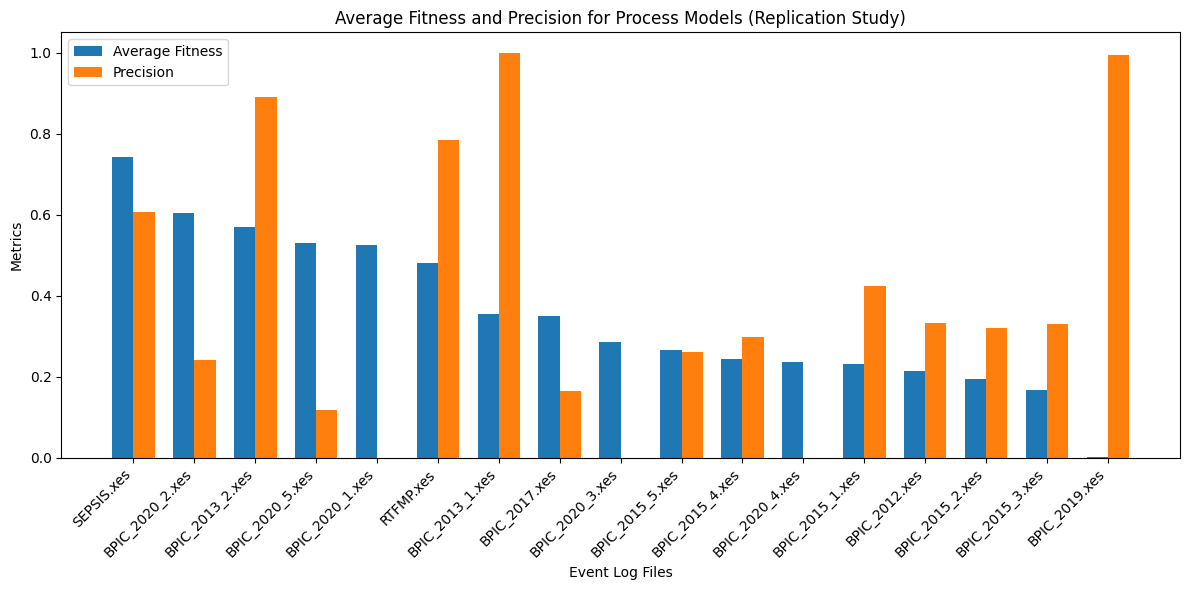

In [63]:
# Sort the DataFrame by 'averageFitness' in descending order
evaluation_results_df = evaluation_results_df.sort_values(by="averageFitness", ascending=False)

# Reset the index after sorting to maintain order consistency
evaluation_results_df = evaluation_results_df.reset_index(drop=True)

# Plot precision and average fitness
plt.figure(figsize=(12, 6))

x = range(len(evaluation_results_df))  # Number of files
width = 0.35  # Width of the bars

# Precision and Fitness values
precision_values = evaluation_results_df["precision"]
fitness_values = evaluation_results_df["averageFitness"]
file_names = evaluation_results_df["File"]

# Create bar chart
plt.bar([i - width / 2 for i in x], fitness_values, width, label='Average Fitness')
plt.bar([i + width / 2 for i in x], precision_values, width, label='Precision')

# Add labels and title
plt.xticks(ticks=x, labels=file_names, rotation=45, ha='right')
plt.xlabel('Event Log Files')
plt.ylabel('Metrics')
plt.title('Average Fitness and Precision for Process Models (Replication Study)')
plt.legend()
plt.tight_layout()

filename = "fit_vs_prec_barplot.png"
filepath = os.path.join(r'..\results', filename)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

##### Comparing author's results with replication results

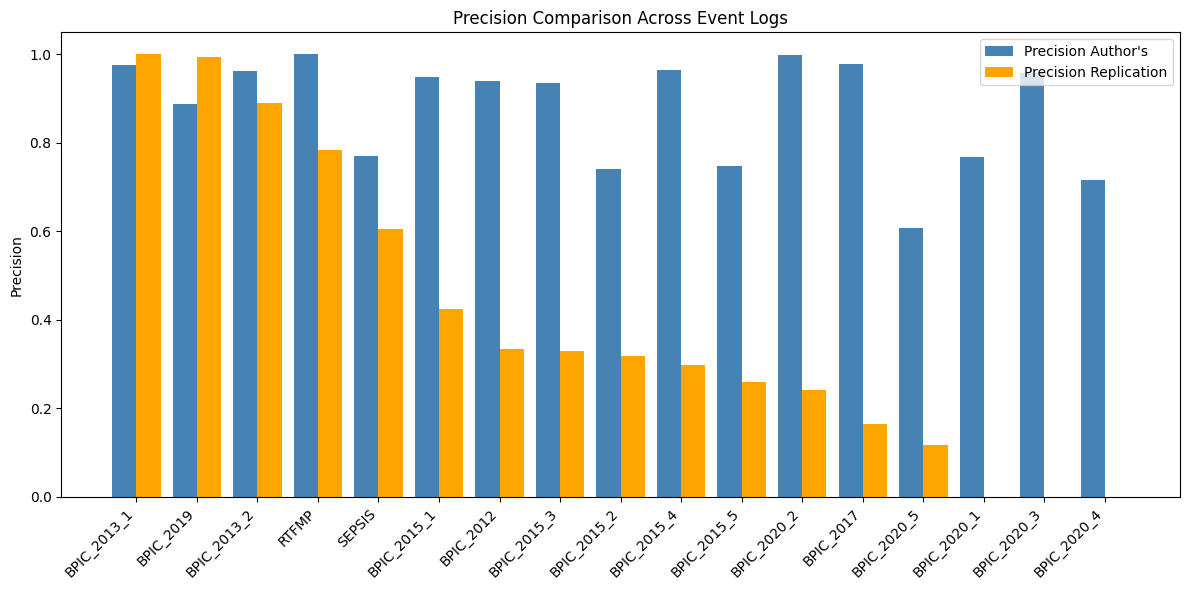

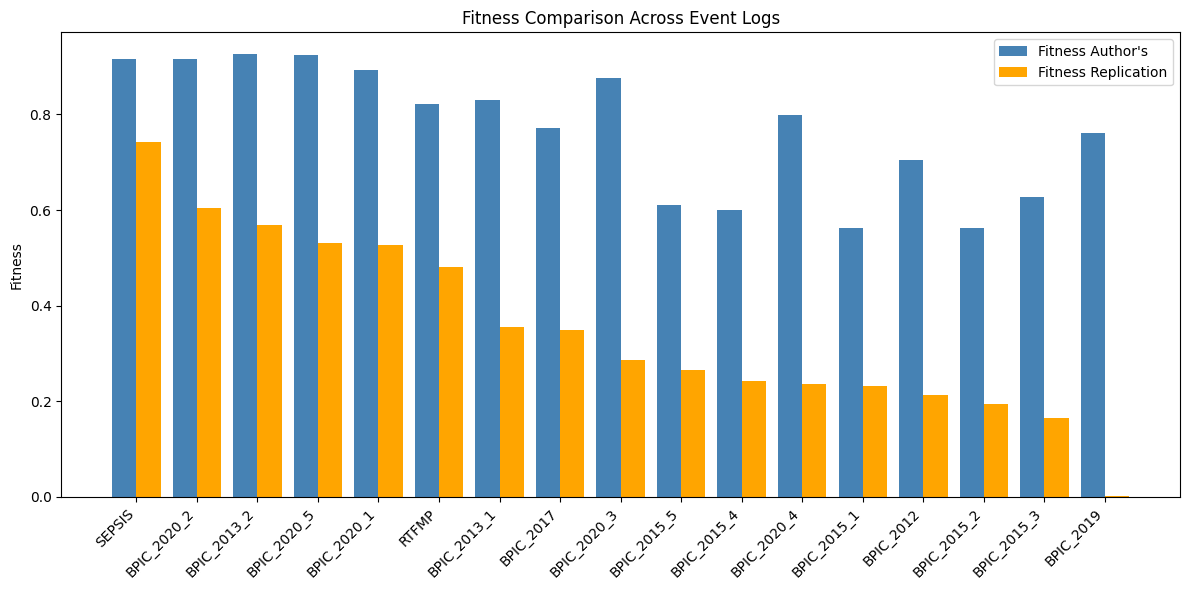

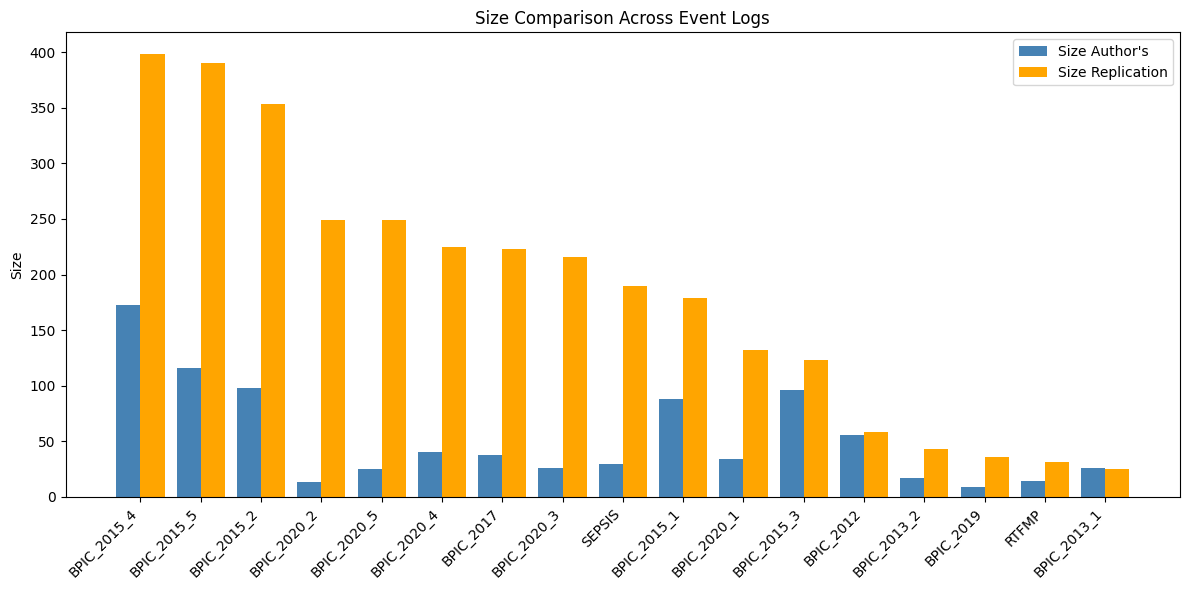

In [56]:
def plot_bar_for_all_metrics(df):
    metrics = ['Precision', 'Fitness', 'Size']

    for metric in metrics:
        sorted_df = df.sort_values(by=f'{metric} Replication', ascending=False)
        plt.figure(figsize=(12, 6))

        labels = sorted_df['Event Log']
        x = range(len(labels))
        width = 0.4

        # Plot Author's and Replication values
        plt.bar([pos - width / 2 for pos in x], sorted_df[f'{metric} Author\'s'], width=width, label=f"{metric} Author's", color='steelblue')
        plt.bar([pos + width / 2 for pos in x], sorted_df[f'{metric} Replication'], width=width, label=f"{metric} Replication", color='orange')

        # Add labels and title
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison Across Event Logs')
        plt.xticks(x, labels, rotation=45, ha='right')
        plt.legend()
        
        plt.tight_layout()

        filename = f"{metric.lower()}_comparison_barplot.png"
        filepath = os.path.join(r'..\results', filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

        plt.show()

# Call the bar chart function
plot_bar_for_all_metrics(comp_df)

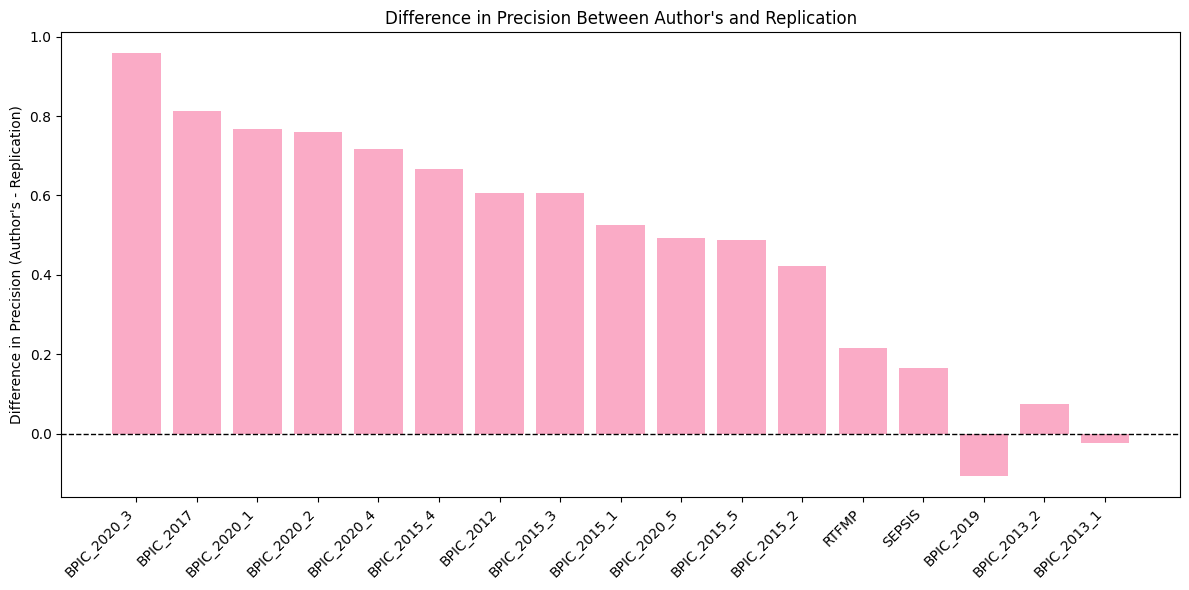

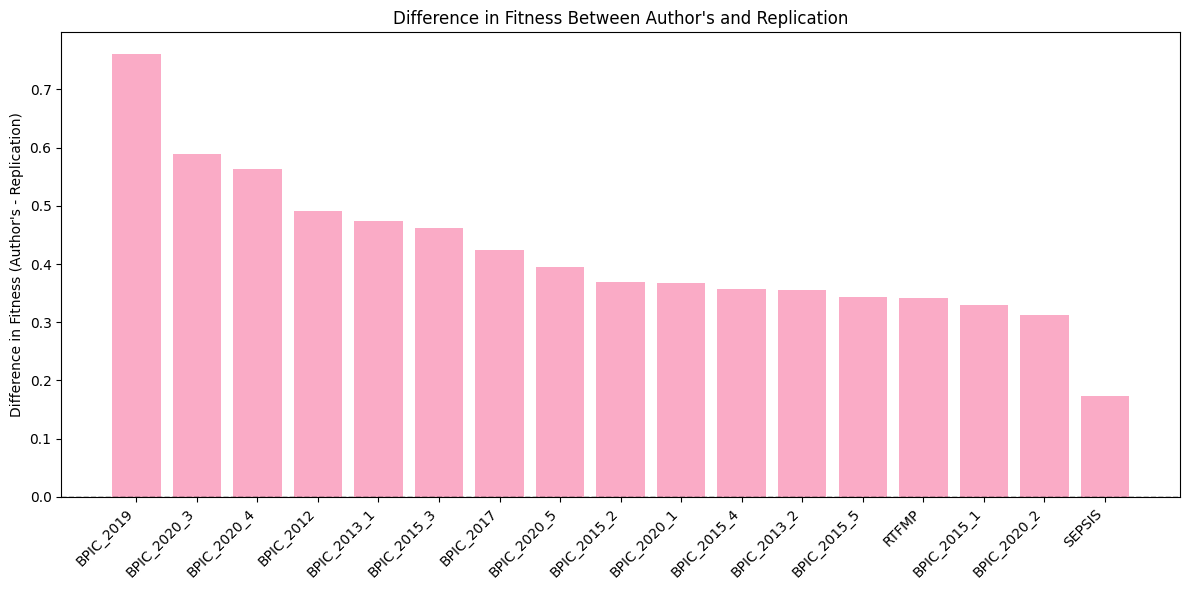

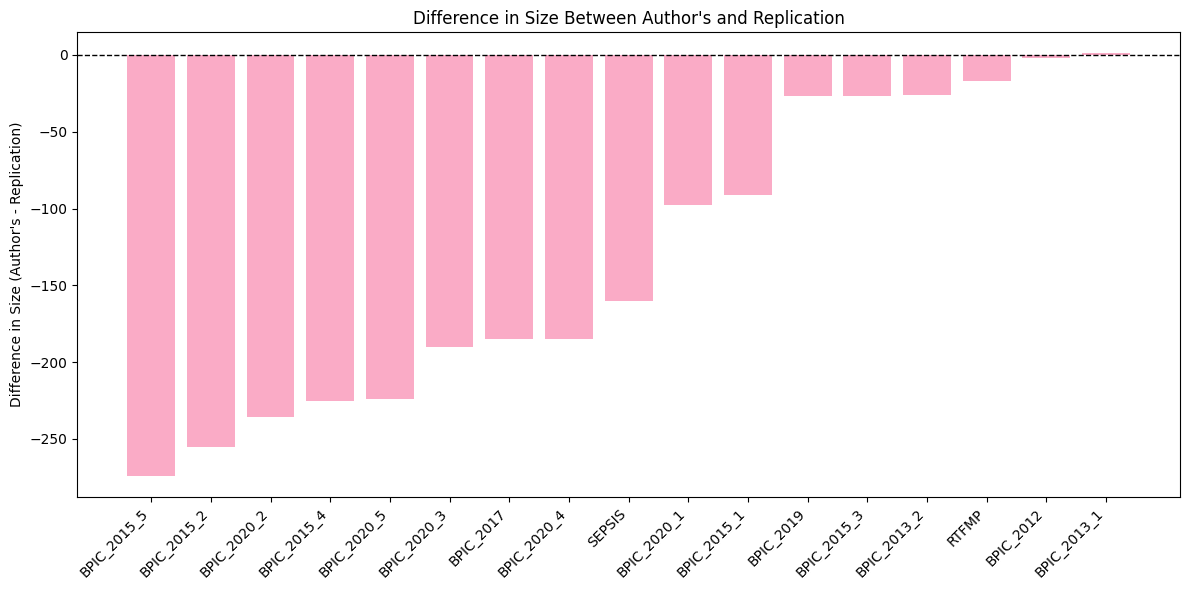

In [55]:
def plot_ordered_difference_for_all_metrics(df):
    metrics = ['Precision', 'Fitness', 'Size']

    for metric in metrics:
        # Calculate the difference between Author's and Replication
        df[f'{metric} Difference'] = df[f'{metric} Author\'s'] - df[f'{metric} Replication']

        # Sort the DataFrame by the absolute value of the difference
        sorted_df = df.sort_values(by=f'{metric} Difference', key=abs, ascending=False)

        plt.figure(figsize=(12, 6))

        # Plot the differences as a bar chart
        plt.bar(sorted_df['Event Log'], sorted_df[f'{metric} Difference'], color='#f988af', alpha=0.7)

        # Add labels and title
        plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Reference line at 0
        plt.ylabel(f'Difference in {metric} (Author\'s - Replication)')
        plt.title(f'Difference in {metric} Between Author\'s and Replication')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()

        filename = f"{metric.lower()}_difference_ordered_chart.png"
        filepath = os.path.join(r'..\results', filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

        plt.show()

# Call the function to generate ordered difference plots
plot_ordered_difference_for_all_metrics(comp_df)


##### Bar/Line Chart

,precision,size,averageFitness,File,Event Log
0,0.606031,190,0.742092,SEPSIS.xes,SEPSIS
1,0.240812,249,0.604131,BPIC_2020_2.xes,BPIC_2020_2
2,0.889921,43,0.569179,BPIC_2013_2.xes,BPIC_2013_2
3,0.116582,249,0.530830,BPIC_2020_5.xes,BPIC_2020_5
4,0.000000,132,0.525912,BPIC_2020_1.xes,BPIC_2020_1
5,0.783693,31,0.480299,RTFMP.xes,RTFMP
6,1.000000,25,0.355742,BPIC_2013_1.xes,BPIC_2013_1
7,0.164954,223,0.348540,BPIC_2017.xes,BPIC_2017
8,0.000000,216,0.286586,BPIC_2020_3.xes,BPIC_2020_3
9,0.260699,390,0.265966,BPIC_2015_5.xes,BPIC_2015_5


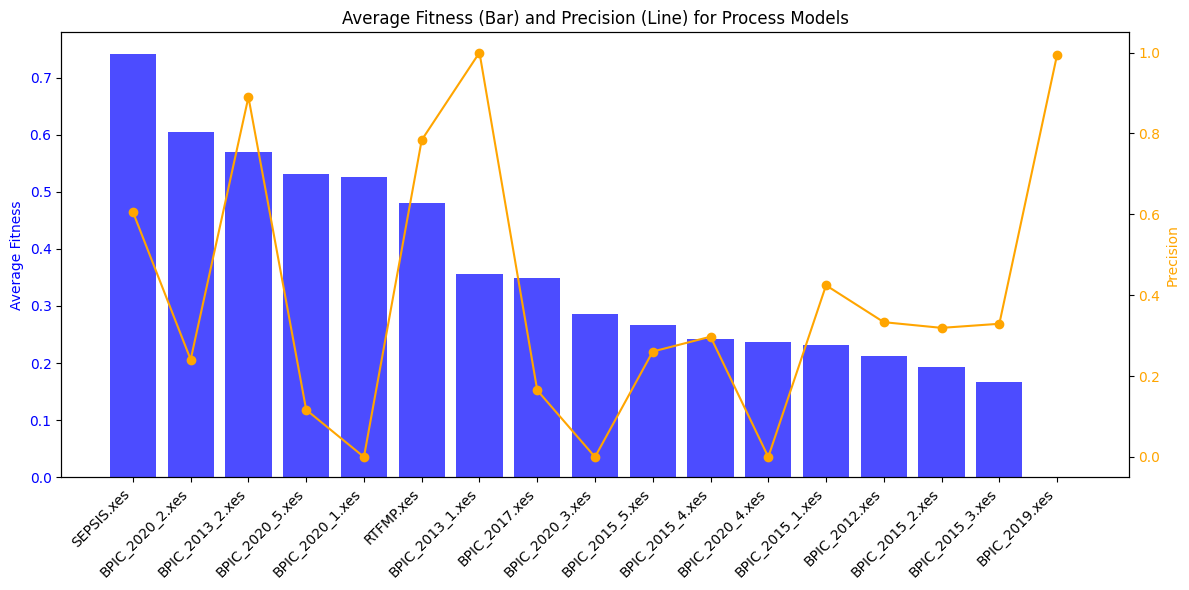

In [64]:
# Sort the DataFrame by 'averageFitness' in descending order
evaluation_results_df = evaluation_results_df.sort_values(by="averageFitness", ascending=False)

# Reset the index after sorting to maintain order consistency
evaluation_results_df = evaluation_results_df.reset_index(drop=True)

# Display the results
display(evaluation_results_df)

# Plot precision and average fitness
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(evaluation_results_df))  # Number of files
file_names = evaluation_results_df["File"]

# Bar chart for precision
precision_values = evaluation_results_df["precision"]
ax1.bar(x, fitness_values, color='blue', alpha=0.7, label='Average Fitness')
ax1.set_ylabel('Average Fitness', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for average fitness
fitness_values = evaluation_results_df["averageFitness"]
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(x, precision_values, color='orange', marker='o', label='Precision')
ax2.set_ylabel('Precision', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# X-axis labels
ax1.set_xticks(x)  # Set x-ticks on the primary axis
ax1.set_xticklabels(file_names, rotation=45, ha='right')  # Rotate labels here

# Title and legend
plt.title('Average Fitness (Bar) and Precision (Line) for Process Models')
plt.tight_layout()

filename = "lineplot_barplot.png"
filepath = os.path.join(r'..\results', filename)
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

##### Visualization Process Tree & Process Map

In [61]:
import os
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.objects.log.importer.xes import importer as xes_importer

# Visualization function for process tree
def visualize_process_tree(process_tree, output_file):
    gviz = pt_visualizer.apply(process_tree)
    pt_visualizer.save(gviz, output_file)
    print(f"Process tree saved to {output_file}")

# Visualization function for process map
def visualize_process_map(log, output_file):
    dfg = dfg_discovery.apply(log)
    gviz = dfg_visualizer.apply(dfg)
    dfg_visualizer.save(gviz, output_file)
    print(f"Process map saved to {output_file}")

# Directory containing the XES files
input_path = r"..\data\event_logs"
output_path = "visualizations"
os.makedirs(output_path, exist_ok=True)

# Initialize AIM
aim = ApproximateInductiveMiner()

# Process all files in the directory
for file_name in os.listdir(input_path):
    if file_name.endswith(".xes"):  # Ensure only XES files are processed
        try:
            # Load the event log
            log_path = os.path.join(input_path, file_name)
            log = xes_importer.apply(log_path)
            
            # Create a subdirectory for each file
            base_name = os.path.splitext(file_name)[0]
            file_output_path = os.path.join(output_path, base_name)
            os.makedirs(file_output_path, exist_ok=True)
            
            # Generate output file names in the subdirectory
            tree_output_file = os.path.join(file_output_path, f"{base_name}_process_tree.png")
            initial_map_file = os.path.join(file_output_path, f"{base_name}_initial_process_map.png")
            filtered_map_file = os.path.join(file_output_path, f"{base_name}_filtered_process_map.png")
            
            # Discover the process tree
            process_tree = aim.discover_process_tree(log)
            
            # Visualize and save the process tree
            visualize_process_tree(process_tree, output_file=tree_output_file)
            
            # Visualize the initial process map
            visualize_process_map(log, output_file=initial_map_file)
            
            # Apply filtering and visualize the filtered process map
            filtered_log, _ = aim.filter_event_log(log, threshold=0.1)
            visualize_process_map(filtered_log, output_file=filtered_map_file)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")


parsing log, completed traces :: 100%|██████████| 13087/13087 [00:07<00:00, 1707.80it/s]


Error processing file BPIC_2012.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 7554/7554 [00:04<00:00, 1696.45it/s]


Error processing file BPIC_2013_1.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 1487/1487 [00:00<00:00, 2384.98it/s]


Error processing file BPIC_2013_2.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 1199/1199 [00:04<00:00, 295.17it/s]


Error processing file BPIC_2015_1.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 832/832 [00:02<00:00, 308.78it/s]


Error processing file BPIC_2015_2.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 1409/1409 [00:04<00:00, 323.33it/s]


Error processing file BPIC_2015_3.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 1053/1053 [00:02<00:00, 374.85it/s]


Error processing file BPIC_2015_4.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 1156/1156 [00:03<00:00, 315.24it/s]


Error processing file BPIC_2015_5.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:49<00:00, 635.60it/s]


Error processing file BPIC_2017.xes: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


parsing log, completed traces ::  13%|█▎        | 33514/251734 [00:09<00:50, 4342.06it/s]

KeyboardInterrupt: 

parsing log, completed traces ::  13%|█▎        | 33548/251734 [00:23<00:50, 4342.06it/s]

In [ ]:
#Back Up

# Printing each Tree & Map for filter values from 0.1 till 0.8 ()

In [ ]:
""" 
import os
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.objects.log.importer.xes import importer as xes_importer

# Visualization function for process tree
def visualize_process_tree(process_tree, output_file):
    gviz = pt_visualizer.apply(process_tree)
    pt_visualizer.save(gviz, output_file)
    print(f"Process tree saved to {output_file}")

# Visualization function for process map
def visualize_process_map(log, output_file):
    dfg = dfg_discovery.apply(log)
    gviz = dfg_visualizer.apply(dfg)
    dfg_visualizer.save(gviz, output_file)
    print(f"Process map saved to {output_file}")

# Directory containing the XES files
input_path = r"C:\Users\Musta\Documents\Universiy of Vienna\3. Semester\Business Intelligence II\AIM_GROUP_3\event_logs"
output_path = "visualizations"
os.makedirs(output_path, exist_ok=True)

# Initialize AIM
filter_steps = 10  # Adjust filter steps if needed
aim = ApproximateInductiveMiner(filter_steps=filter_steps)

# Process all files in the directory
for file_name in os.listdir(input_path):
    if file_name.endswith(".xes"):  # Ensure only XES files are processed
        try:
            # Load the event log
            log_path = os.path.join(input_path, file_name)
            log = xes_importer.apply(log_path)
            
            # Create a subdirectory for each file
            base_name = os.path.splitext(file_name)[0]
            file_output_path = os.path.join(output_path, base_name)
            os.makedirs(file_output_path, exist_ok=True)
            
            # Generate output file names for the initial visualizations
            tree_output_file = os.path.join(file_output_path, f"{base_name}_process_tree.png")
            initial_map_file = os.path.join(file_output_path, f"{base_name}_initial_process_map.png")
            
            # Visualize the initial process tree and map
            process_tree = aim.discover_process_tree(log)
            visualize_process_tree(process_tree, output_file=tree_output_file)
            visualize_process_map(log, output_file=initial_map_file)
            
            # Apply dynamic filtering and visualize for each filter value
            for filter_value in aim.filter_values:
                filtered_log, _ = aim.filter_event_log(log, threshold=filter_value)
                
                # Generate file names for filtered visualizations
                filtered_tree_file = os.path.join(file_output_path, f"{base_name}_tree_filtered_{filter_value:.2f}.png")
                filtered_map_file = os.path.join(file_output_path, f"{base_name}_map_filtered_{filter_value:.2f}.png")
                
                # Discover process tree and visualize filtered logs
                filtered_tree = aim.discover_process_tree(filtered_log)
                visualize_process_tree(filtered_tree, output_file=filtered_tree_file)
                visualize_process_map(filtered_log, output_file=filtered_map_file)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
"""

aligning log, completed variants :: 100%|██████████| 183/183 [00:01<00:00, 108.33it/s]
computing precision with alignments, completed variants :: 100%|██████████| 585/585 [00:00<00:00, 820.83it/s] 
aligning log, completed variants :: 100%|██████████| 202/202 [00:01<00:00, 131.00it/s]
computing precision with alignments, completed variants :: 100%|██████████| 903/903 [00:00<00:00, 1296.38it/s]
aligning log, completed variants :: 100%|██████████| 89/89 [00:01<00:00, 79.65it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 257/257 [00:00<00:00, 930.52it/s] 


,precision,size,averageFitness,File
0,0.889921,43,0.569179,BPI_Challenge_2013_closed_problems.xes
1,0.000000,216,0.286586,PrepaidTravelCost.xes
2,0.000000,225,0.235998,RequestForPayment.xes


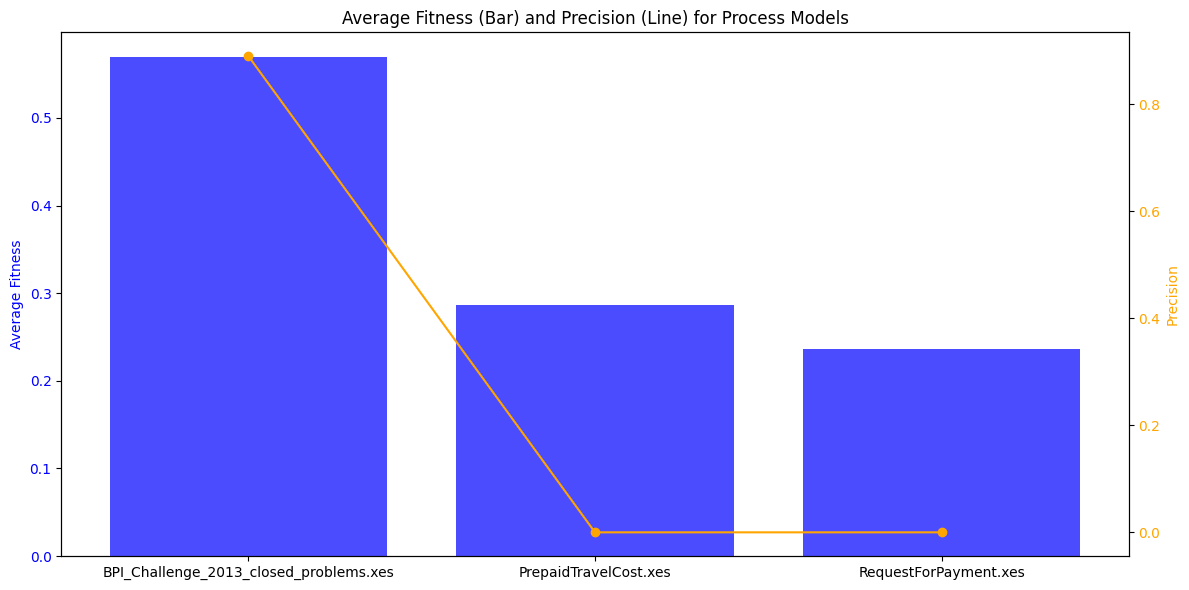

In [16]:
"""
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Define extracted files path and list them
extract_path = r"C:\Users\Musta\Documents\Universiy of Vienna\3. Semester\Business Intelligence II\AIM_GROUP_3\event_logs"
extracted_files = os.listdir(extract_path)

# Initialize the miner
aim = ApproximateInductiveMiner()

# Placeholder for results
algorithm_results = []

# Process each event log file
for file in extracted_files:
    file_path = os.path.join(extract_path, file)
    try:
        # Import the event log
        log = xes_importer.apply(file_path)
        
        # Discover the process tree using the miner
        process_tree = aim.discover_process_tree(log)
        
        # Evaluate the discovered model
        evaluation_metrics = aim.evaluate_model(log, process_tree)
        
        # Extract fitness and precision
        fitness_data = evaluation_metrics.get('fitness', {})
        average_fitness = fitness_data.get('averageFitness', None)  # Extract averageFitness
        evaluation_metrics['averageFitness'] = average_fitness
        evaluation_metrics.pop('fitness', None)  # Remove the nested fitness dictionary
        
        # Ensure the file name is added to evaluation_metrics
        evaluation_metrics['File'] = file
        
        algorithm_results.append(evaluation_metrics)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert results to a DataFrame for visualization
evaluation_results_df = pd.DataFrame(algorithm_results)



"""

Back Up (With Preprocessing)

In [ ]:
"""
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Define extracted files path and list them
extract_path = r"C:\Users\Musta\Documents\Universiy of Vienna\3. Semester\Business Intelligence II\AIM_GROUP_3\event_logs"
extracted_files = os.listdir(extract_path)

# Initialize the miner
aim = ApproximateInductiveMiner()

# Placeholder for results
algorithm_results = []

# Process each event log file
for file in extracted_files:
    file_path = os.path.join(extract_path, file)
    try:
        # Import the event log
        log = xes_importer.apply(file_path)
        
        # Discover the process tree using the miner
        process_tree = aim.discover_process_tree(log)
        
        # Evaluate the discovered model
        evaluation_metrics = aim.evaluate_model(log, process_tree)
        
        # Extract fitness and precision
        fitness_data = evaluation_metrics.get('fitness', {})
        average_fitness = fitness_data.get('averageFitness', None)  # Extract averageFitness
        evaluation_metrics['averageFitness'] = average_fitness
        evaluation_metrics.pop('fitness', None)  # Remove the nested fitness dictionary
        
        # Ensure the file name is added to evaluation_metrics
        evaluation_metrics['File'] = file
        
        algorithm_results.append(evaluation_metrics)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert results to a DataFrame for visualization
evaluation_results_df = pd.DataFrame(algorithm_results)


"""